In [21]:
%matplotlib inline

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import gymnasium as gym
from gymnasium import Env, spaces
from scipy.special import comb
from collections import defaultdict

In [23]:
# Load the parameters from the pickle file
with open('pickles/anonbank_best_fit_params.pkl', 'rb') as f:
    best_fit_params_df = pickle.load(f)

# Convert to dictionary for easier access
best_fit_params_dict = best_fit_params_df.set_index('param_name').T.to_dict()

best_fit_params_dict

{('1', 'REGULAR'): {'shape': 0.8730464230836799,
  'loc': -18.81216413263904,
  'scale': 125.46378302666686},
 ('1', 'SPECIFIC'): {'shape': 1.214960359497789,
  'loc': -6.43006717763892,
  'scale': 107.29065148469789},
 ('2', 'REGULAR'): {'shape': 0.8338496982819321,
  'loc': -8.97654648869145,
  'scale': 150.28787524753483},
 ('2', 'SPECIFIC'): {'shape': 1.025678942745753,
  'loc': -4.806412598886724,
  'scale': 101.20889024937449},
 'REGULAR': {'shape': 1.0504388160598739,
  'loc': -2.846758403840244,
  'scale': 42.90266397968547},
 'SPECIFIC': {'shape': 1.1336708937695927,
  'loc': -5.260938954957395,
  'scale': 104.59652892248457},
 'REGULAR_x4': {'shape': 1.0504388160598708,
  'loc': -11.387033615361277,
  'scale': 171.6106559187423},
 'SPECIFIC_x4': {'shape': 1.1336708937695894,
  'loc': -21.043755819830228,
  'scale': 418.38611568993946}}

In [24]:
with open('pickles/anonbank_lognorm_params.pkl', 'rb') as f:
    lognorm_params_df = pickle.load(f)
    
lognorm_params_dict = lognorm_params_df.set_index('param_name').T.to_dict()

lognorm_params_dict

{('1', 'REGULAR'): {'mu': 4.832017135463374,
  'sigma': 0.006958469079704907,
  'loc': -18.81216413263904},
 ('1', 'SPECIFIC'): {'mu': 4.6755415208149325,
  'sigma': 0.011323646523065594,
  'loc': -6.43006717763892},
 ('2', 'REGULAR'): {'mu': 5.0125526231624855,
  'sigma': 0.005548307071802354,
  'loc': -8.97654648869145},
 ('2', 'SPECIFIC'): {'mu': 4.617186601308905,
  'sigma': 0.010134016947128502,
  'loc': -4.806412598886724},
 'REGULAR': {'mu': 3.7589339214345716,
  'sigma': 0.024480564633599006,
  'loc': -2.846758403840244},
 'SPECIFIC': {'mu': 4.650110366782741,
  'sigma': 0.01083819523964822,
  'loc': -5.260938954957395},
 'REGULAR_x4': {'mu': 5.145228282554465,
  'sigma': 0.006121000886257698,
  'loc': -11.387033615361277},
 'SPECIFIC_x4': {'mu': 6.036404727902634,
  'sigma': 0.002709623408600959,
  'loc': -21.043755819830228}}

In [25]:
# Global variables

# Queue size
MAX_QUEUE_SIZE = 20

# Discount factor for future rewards
DISCOUNT = 0.95

# Penalty for dropping calls (when queue is full)
DROP_PENALTY = 3600.0 # 1 hour in seconds

# State space: (queue 1 size, queue 2 size, call type)
STATE_SPACE = (MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1, 2)

# Call type: 0 = regular, 1 = specific
CALL_TYPE = [0, 1]

# Actions: 0 = route to queue 1, 1 = route to queue 2
ACTIONS = [1, 2]

# Arrival parameters for regular and specific calls
ARRIVAL_REGULAR_MU = lognorm_params_dict['REGULAR']['mu']
ARRIVAL_REGULAR_SIGMA = lognorm_params_dict['REGULAR']['sigma']
ARRIVAL_REGULAR_LOC = lognorm_params_dict['REGULAR']['loc']

ARRIVAL_SPECIFIC_MU = lognorm_params_dict['SPECIFIC']['mu']
ARRIVAL_SPECIFIC_SIGMA = lognorm_params_dict['SPECIFIC']['sigma']
ARRIVAL_SPECIFIC_LOC = lognorm_params_dict['SPECIFIC']['loc']

ARRIVAL_REGULAR_X4_MU = lognorm_params_dict['REGULAR_x4']['mu']
ARRIVAL_REGULAR_X4_SIGMA = lognorm_params_dict['REGULAR_x4']['sigma']
ARRIVAL_REGULAR_X4_LOC = lognorm_params_dict['REGULAR_x4']['loc']

ARRIVAL_SPECIFIC_X4_MU = lognorm_params_dict['SPECIFIC_x4']['mu']
ARRIVAL_SPECIFIC_X4_SIGMA = lognorm_params_dict['SPECIFIC_x4']['sigma']
ARRIVAL_SPECIFIC_X4_LOC = lognorm_params_dict['SPECIFIC_x4']['loc']

SERVICE_REGULAR_1_MU = lognorm_params_dict[('1', 'REGULAR')]['mu']
SERVICE_REGULAR_1_SIGMA = lognorm_params_dict[('1', 'REGULAR')]['sigma']
SERVICE_REGULAR_1_LOC = lognorm_params_dict[('1', 'REGULAR')]['loc']
SERVICE_SPECIFIC_1_MU = lognorm_params_dict[('1', 'SPECIFIC')]['mu']
SERVICE_SPECIFIC_1_SIGMA = lognorm_params_dict[('1', 'SPECIFIC')]['sigma']
SERVICE_SPECIFIC_1_LOC = lognorm_params_dict[('1', 'SPECIFIC')]['loc']

SERVICE_REGULAR_2_MU = lognorm_params_dict[('2', 'REGULAR')]['mu']
SERVICE_REGULAR_2_SIGMA = lognorm_params_dict[('2', 'REGULAR')]['sigma']
SERVICE_REGULAR_2_LOC = lognorm_params_dict[('2', 'REGULAR')]['loc']
SERVICE_SPECIFIC_2_MU = lognorm_params_dict[('2', 'SPECIFIC')]['mu']
SERVICE_SPECIFIC_2_SIGMA = lognorm_params_dict[('2', 'SPECIFIC')]['sigma']
SERVICE_SPECIFIC_2_LOC = lognorm_params_dict[('2', 'SPECIFIC')]['loc']

def mean_shifted_lognormal(mu, sigma, loc):
    """
    Calculate mean of shifted lognormal distribution:
    E[X] = exp(mu + sigma^2 / 2) + loc
    """
    return np.exp(mu + (sigma**2) / 2) + loc

# Arrival rates

ARRIVAL_REGULAR = mean_shifted_lognormal(
    ARRIVAL_REGULAR_MU,
    ARRIVAL_REGULAR_SIGMA,
    ARRIVAL_REGULAR_LOC
)

ARRIVAL_SPECIFIC = mean_shifted_lognormal(
    ARRIVAL_SPECIFIC_MU,
    ARRIVAL_SPECIFIC_SIGMA,
    ARRIVAL_SPECIFIC_LOC
)

ARRIVAL_REGULAR_X4 = mean_shifted_lognormal(
    ARRIVAL_REGULAR_X4_MU,
    ARRIVAL_REGULAR_X4_SIGMA,
    ARRIVAL_REGULAR_X4_LOC
)

ARRIVAL_SPECIFIC_X4 = mean_shifted_lognormal(
    ARRIVAL_SPECIFIC_X4_MU,
    ARRIVAL_SPECIFIC_X4_SIGMA,
    ARRIVAL_SPECIFIC_X4_LOC
)

# Service rates

SERVICE_REGULAR_1 = mean_shifted_lognormal(
    SERVICE_REGULAR_1_MU,
    SERVICE_REGULAR_1_SIGMA,
    SERVICE_REGULAR_1_LOC
)

SERVICE_REGULAR_2 = mean_shifted_lognormal(
    SERVICE_REGULAR_2_MU,
    SERVICE_REGULAR_2_SIGMA,
    SERVICE_REGULAR_2_LOC
)

SERVICE_SPECIFIC_1 = mean_shifted_lognormal(
    SERVICE_SPECIFIC_1_MU,
    SERVICE_SPECIFIC_1_SIGMA,
    SERVICE_SPECIFIC_1_LOC
)

SERVICE_SPECIFIC_2 = mean_shifted_lognormal(
    SERVICE_SPECIFIC_2_MU,
    SERVICE_SPECIFIC_2_SIGMA,
    SERVICE_SPECIFIC_2_LOC
)

In [26]:
print(f"ARRIVAL_REGULAR: {ARRIVAL_REGULAR}, ARRIVAL_SPECIFIC: {ARRIVAL_SPECIFIC}")
print(f"ARRIVAL_REGULAR_X4: {ARRIVAL_REGULAR_X4}, ARRIVAL_SPECIFIC_X4: {ARRIVAL_SPECIFIC_X4}")
print(f"SERVICE_REGULAR_1: {SERVICE_REGULAR_1}, SERVICE_SPECIFIC_1: {SERVICE_SPECIFIC_1}")
print(f"SERVICE_REGULAR_2: {SERVICE_REGULAR_2}, SERVICE_SPECIFIC_2: {SERVICE_SPECIFIC_2}") 

ARRIVAL_REGULAR: 40.068763243462236, ARRIVAL_SPECIFIC: 99.34173344076834
ARRIVAL_REGULAR_X4: 160.22683717184307, ARRIVAL_SPECIFIC_X4: 397.3438957807048
SERVICE_REGULAR_1: 106.65465642729778, SERVICE_SPECIFIC_1: 100.86746319788303
SERVICE_REGULAR_2: 141.3136419859323, SERVICE_SPECIFIC_2: 96.4076747743812


In [27]:
# Lognormal expected value calculation

def expected_waiting_time_lognormal(q_size, p_regular, mean_s, mean_c):
    """
    Calculate expected waiting time for a queue with q_size calls,
    each call being regular with probability p_regular,
    using direct mean service times for regular and specific calls.
    """
    wait = 0.0
    for k in range(q_size + 1):
        # Binomial probability of k regular calls in the queue
        prob = comb(q_size, k) * (p_regular ** k) * ((1 - p_regular) ** (q_size - k))
        # Waiting time if k regular and (q_size - k) specific ahead
        wait_k = k * mean_s + (q_size - k) * mean_c
        wait += prob * wait_k

    # Add mean service time for the current arriving call (assumed regular here)
    wait += mean_s
    return wait


In [28]:
# Example usage to calculate expected waiting time for queue 1:

rate_regular = 1 / ARRIVAL_REGULAR
rate_specific = 1 / ARRIVAL_SPECIFIC

p_regular = rate_regular / (rate_regular + rate_specific)

mean_s1 = SERVICE_REGULAR_1

mean_c1 = SERVICE_SPECIFIC_1

q1 = 10 # Example queue size

expected_wait = expected_waiting_time_lognormal(q1, p_regular, mean_s1, mean_c1)
print(f"Expected waiting time at queue 1: {expected_wait:.4f}")

# Compare with queue 2

mean_s2 = SERVICE_REGULAR_2

mean_c2 = SERVICE_SPECIFIC_2

expected_wait = expected_waiting_time_lognormal(q1, p_regular, mean_s2, mean_c2) # Assuming same queue size for simplicity
print(f"Expected waiting time at queue 2: {expected_wait:.4f}")

Expected waiting time at queue 1: 1156.5679
Expected waiting time at queue 2: 1425.3833


In [ ]:
class CallCentreMDPEnv:
    """
    RL environment for a two-queue call centre.
    State: (q1_length, q2_length, call_type)
    Action: 0 = route to queue 1, 1 = queue 2
    Reward: Negative expected waiting time (cost to minimise)
    """
    def __init__(self, max_queue=10, drop_penalty=1000.0, seed=1901448):
        self.max_queue = max_queue
        self.drop_penalty = drop_penalty
        self.state = None
        
        # Use your actual service time means
        self.service_means = {
            (1, 0): SERVICE_REGULAR_1,    # Queue 1, Regular calls
            (1, 1): SERVICE_SPECIFIC_1,   # Queue 1, Specific calls  
            (2, 0): SERVICE_REGULAR_2,    # Queue 2, Regular calls
            (2, 1): SERVICE_SPECIFIC_2,   # Queue 2, Specific calls
        }
        
        self.p_regular = p_regular
        
        # Track queue lengths only (not actual service times for simplicity)
        self.queue1_length = 0
        self.queue2_length = 0
        self.seed(seed)

    def seed(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

    def reset(self):
        """Reset environment to initial state"""
        self.queue1_length = 0
        self.queue2_length = 0
        call_type = np.random.choice([0, 1], p=[self.p_regular, 1 - self.p_regular])
        self.state = (0, 0, call_type)
        return self.state

    def _expected_waiting_time(self, queue_num, queue_length, call_type):
        """
        Calculate expected waiting time for a call in given queue
        """
        if queue_length == 0:
            return 0.0  # No waiting if queue is empty
        
        # Expected service time for calls currently in queue
        # Assume they're distributed according to arrival probabilities
        expected_service_in_queue = (
            self.p_regular * self.service_means[(queue_num, 0)] + 
            (1 - self.p_regular) * self.service_means[(queue_num, 1)]
        )
        
        # Expected waiting time = queue_length * expected_service_time_per_call
        return queue_length * expected_service_in_queue

    def step(self, action):
        q1_len, q2_len, call_type = self.state
        dropped = False
        
        # Check if chosen queue is full
        if action == 0 and q1_len >= self.max_queue:
            reward = -self.drop_penalty  # High penalty for dropping calls
            dropped = True
        elif action == 1 and q2_len >= self.max_queue:
            reward = -self.drop_penalty  # High penalty for dropping calls
            dropped = True
        else:
            # Calculate expected waiting time for this call
            if action == 0:  # Route to queue 1
                expected_wait = self._expected_waiting_time(1, q1_len, call_type)
                self.queue1_length = min(q1_len + 1, self.max_queue)
            else:  # Route to queue 2
                expected_wait = self._expected_waiting_time(2, q2_len, call_type)
                self.queue2_length = min(q2_len + 1, self.max_queue)
            
            # Reward is negative waiting time (cost to minimize)
            reward = -expected_wait
            dropped = False

        # Simulate some calls completing (simplified)
        # Randomly reduce queue lengths based on completion probability
        completion_prob = 0.3  # Probability a call completes each step
        
        if self.queue1_length > 0 and np.random.random() < completion_prob:
            self.queue1_length -= 1
        if self.queue2_length > 0 and np.random.random() < completion_prob:
            self.queue2_length -= 1
            
        # Generate next call type
        next_call_type = np.random.choice([0, 1], p=[self.p_regular, 1 - self.p_regular])
        self.state = (self.queue1_length, self.queue2_length, next_call_type)
        
        done = False  # Infinite horizon
        info = {"dropped": dropped}
        
        return self.state, reward, done, info

In [30]:
def q_learning_with_debugging(
    env,
    num_episodes=5000,
    max_steps_per_episode=200,
    alpha=0.1,
    gamma=0.9,  # Lower discount for immediate rewards
    epsilon_start=0.9,  # Start with less exploration
    epsilon_min=0.05,
    epsilon_decay=0.995
):
    """
    Q-learning with debugging information
    """
    Q = defaultdict(lambda: np.zeros(2))
    
    episode_costs = []  # Track actual costs (positive values)
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        state = env.reset()
        state_tuple = tuple(state)
        
        total_reward = 0
        steps = 0
        
        for step in range(max_steps_per_episode):
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.choice([1, 2])
            else:
                best_action_idx = np.argmax(Q[state_tuple])
                action = best_action_idx + 1
            
            next_state, reward, done, info = env.step(action)
            next_state_tuple = tuple(next_state)
            
            # Q-learning update
            best_next_action = np.argmax(Q[next_state_tuple])
            td_target = reward + gamma * Q[next_state_tuple][best_next_action]
            td_error = td_target - Q[state_tuple][action - 1]
            Q[state_tuple][action - 1] += alpha * td_error
            
            state_tuple = next_state_tuple
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        episode_costs.append(-total_reward)  # Convert to positive cost
        
        # Progress logging
        if (episode + 1) % 1000 == 0:
            avg_cost = np.mean(episode_costs[-1000:])  # Average cost over last 1000 episodes
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Avg Cost (last 1000): {avg_cost:.2f}")
            print(f"  Epsilon: {epsilon:.4f}")
            print(f"  States explored: {len(Q)}")
            print()
    
    return Q, episode_costs

In [31]:
def evaluate_policy(env, Q_table, num_episodes=100, policy_name="Q-Learning"):
    """Evaluate a policy without exploration"""
    total_costs = []
    dropped_calls = 0
    total_calls = 0
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_cost = 0
        
        for step in range(200):  # Max steps per episode
            state_tuple = tuple(state)
            
            # Use learned policy (no exploration)
            if state_tuple in Q_table:
                action_idx = np.argmax(Q_table[state_tuple])
                action = action_idx + 1  # Convert zero-based index to action (1 or 2)
            else:
                action = 1  # Default to queue 1 if state not seen
            
            state, reward, done, info = env.step(action)
            episode_cost += (-reward)  # Convert reward to positive cost
            total_calls += 1
            
            if info["dropped"]:
                dropped_calls += 1
            
            if done:
                break
                
        total_costs.append(episode_cost)
    
    avg_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)
    drop_rate = dropped_calls / total_calls if total_calls > 0 else 0
    
    print(f"{policy_name} Policy Evaluation:")
    print(f"  Average cost per episode: {avg_cost:.2f} ± {std_cost:.2f}")
    print(f"  Drop rate: {drop_rate:.4f} ({dropped_calls}/{total_calls})")
    
    return avg_cost, std_cost, drop_rate

In [32]:
def shortest_queue_baseline(env, num_episodes=100):
    """Baseline: always choose the shorter queue"""
    total_costs = []
    dropped_calls = 0
    total_calls = 0
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_cost = 0
        
        for step in range(200):
            q1, q2, call_type = state
            if q1 < q2:
                action = 1
            elif q2 < q1:
                action = 2
            else:
                # Tie-break based on call type
                action = 1 if call_type == 0 else 2
            
            state, reward, done, info = env.step(action)
            episode_cost += (-reward)  # Convert to positive cost
            total_calls += 1
            
            if info["dropped"]:
                dropped_calls += 1
                
            if done:
                break
                
        total_costs.append(episode_cost)
    
    avg_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)
    drop_rate = dropped_calls / total_calls if total_calls > 0 else 0
    
    print("Shortest Queue Baseline:")
    print(f"  Average cost per episode: {avg_cost:.2f} ± {std_cost:.2f}")
    print(f"  Drop rate: {drop_rate:.4f} ({dropped_calls}/{total_calls})")
    
    return avg_cost, std_cost, drop_rate

In [33]:
if __name__ == "__main__":
    print("Call Centre MDP Environment")

    # Compute mean service times for printing
    reg_q1_mean = lognormal_mean(SERVICE_REGULAR_1_MU, SERVICE_REGULAR_1_SIGMA, SERVICE_REGULAR_1_LOC)
    reg_q2_mean = lognormal_mean(SERVICE_REGULAR_2_MU, SERVICE_REGULAR_2_SIGMA, SERVICE_REGULAR_2_LOC)
    spec_q1_mean = lognormal_mean(SERVICE_SPECIFIC_1_MU, SERVICE_SPECIFIC_1_SIGMA, SERVICE_SPECIFIC_1_LOC)
    spec_q2_mean = lognormal_mean(SERVICE_SPECIFIC_2_MU, SERVICE_SPECIFIC_2_SIGMA, SERVICE_SPECIFIC_2_LOC)
    arr_reg_mean = lognormal_mean(ARRIVAL_REGULAR_X4_MU, ARRIVAL_REGULAR_X4_SIGMA, ARRIVAL_REGULAR_X4_LOC)
    arr_spec_mean = lognormal_mean(ARRIVAL_SPECIFIC_X4_MU, ARRIVAL_SPECIFIC_X4_SIGMA, ARRIVAL_SPECIFIC_X4_LOC)

    total_lambda = (1 / lognormal_mean(ARRIVAL_REGULAR_X4_MU, ARRIVAL_REGULAR_X4_SIGMA, ARRIVAL_REGULAR_X4_LOC) +
                    1 / lognormal_mean(ARRIVAL_SPECIFIC_X4_MU, ARRIVAL_SPECIFIC_X4_SIGMA, ARRIVAL_SPECIFIC_X4_LOC))
    p_regular = (1 / lognormal_mean(ARRIVAL_REGULAR_X4_MU, ARRIVAL_REGULAR_X4_SIGMA, ARRIVAL_REGULAR_X4_LOC)) / total_lambda

    print(f"Regular call probability: {p_regular:.3f}")
    print(f"Service times (mean): Q1 Regular = {reg_q1_mean:.1f} s, Specific = {spec_q1_mean:.1f} s")
    print(f"                      Q2 Regular = {reg_q2_mean:.1f} s, Specific = {spec_q2_mean:.1f} s")
    print(f"Arrival times (mean inter-arrival time): Regular = {arr_reg_mean:.1f} s, Specific = {arr_spec_mean:.1f} s")
    print("="*60)

    # Set random seeds for reproducibility
    random.seed(1901448)
    np.random.seed(1901448)

    # Create environment with consistent drop penalty
    env = CallCentreMDPEnv(max_queue=MAX_QUEUE_SIZE, drop_penalty=DROP_PENALTY)

    # Test environment with a few random steps
    print("\nTesting environment:")
    state = env.reset()
    print(f"Initial state: {state}")

    for i in range(3):
        action = random.choice([1, 2])
        state, reward, done, info = env.step(action)
        cost = -reward
        print(f"Step {i+1}: Action={action}, State={state}, Cost={cost:.1f}, Dropped={info['dropped']}")

    print("\n" + "="*60)

    # Evaluate baseline policy
    print("BASELINE EVALUATION:")
    baseline_cost, _, _ = shortest_queue_baseline(env, num_episodes=1000)

    print("\n" + "="*60)

    # Train Q-learning agent
    print("Q-LEARNING TRAINING:")
    Q_table, costs = q_learning_with_debugging(env, num_episodes=10000, epsilon_decay=0.9995, alpha=0.3)

    print("="*60)

    # Evaluate learned policy
    print("LEARNED POLICY EVALUATION:")
    learned_cost, _, _ = evaluate_policy(env, Q_table, num_episodes=1000)

    print("="*60)
    print("FINAL COMPARISON:")
    print(f"Baseline (Shortest Queue): {baseline_cost:.2f}")
    print(f"Q-Learning Policy:         {learned_cost:.2f}")
    improvement = baseline_cost - learned_cost
    print(f"Improvement:               {improvement:.2f}")

    if improvement > 0:
        print("✅ Q-Learning is BETTER (lower cost)")
    else:
        print("❌ Q-Learning is WORSE (higher cost)")

    percent_impr = (improvement / baseline_cost) * 100 if baseline_cost > 0 else 0.0
    print(f"Percentage improvement:    {percent_impr:.2f}%")


Call Centre MDP Environment
Regular call probability: 0.713
Service times (mean): Q1 Regular = 106.7 s, Specific = 100.9 s
                      Q2 Regular = 141.3 s, Specific = 96.4 s
Arrival times (mean inter-arrival time): Regular = 160.2 s, Specific = 397.3 s

Testing environment:
Initial state: (0, 0, np.int64(1))
Step 1: Action=2, State=(0, 1, np.int64(0)), Cost=0.0, Dropped=False
Step 2: Action=2, State=(0, 2, np.int64(0)), Cost=0.0, Dropped=False
Step 3: Action=2, State=(0, 3, np.int64(0)), Cost=0.1, Dropped=False

BASELINE EVALUATION:
Shortest Queue Baseline:
  Average cost per episode: 430371.66 ± 2271.82
  Drop rate: 0.5977 (119542/200000)

Q-LEARNING TRAINING:
Episode 1000/10000
  Avg Cost (last 1000): 431531.98
  Epsilon: 0.5458
  States explored: 757

Episode 2000/10000
  Avg Cost (last 1000): 431658.07
  Epsilon: 0.3310
  States explored: 789

Episode 3000/10000
  Avg Cost (last 1000): 431553.53
  Epsilon: 0.2007
  States explored: 858

Episode 4000/10000
  Avg Cost (las

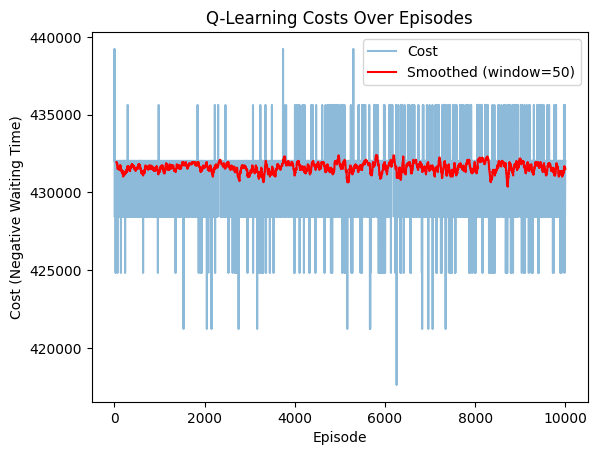

In [34]:
plt.plot(costs, alpha=0.5, label="Cost")
window = 50
smoothed = pd.Series(costs).rolling(window).mean()
plt.plot(smoothed, color='red', label=f"Smoothed (window={window})")
plt.title("Q-Learning Costs Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Cost (Negative Waiting Time)")
plt.legend()
plt.show()

In [ ]:
Q_table

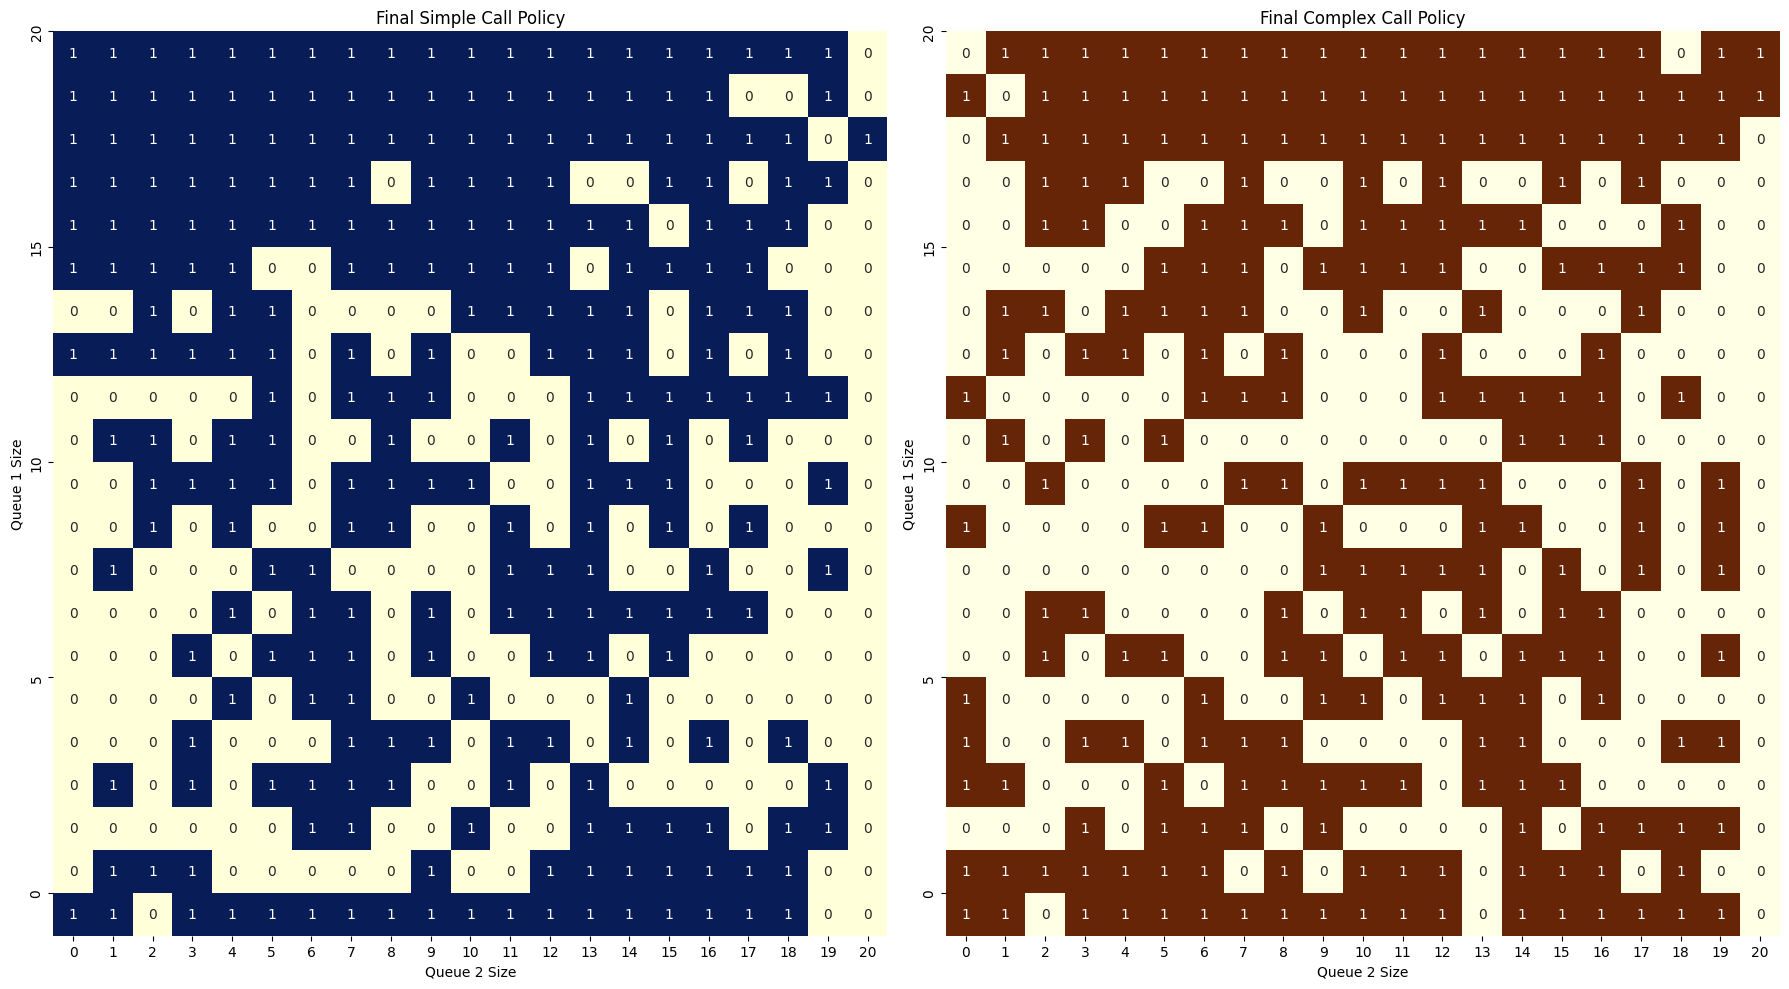

In [35]:
# Plot the Q-table
# Initialize policy arrays
policy_regular = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
policy_specific = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)

# Fill arrays with best actions from Q_table
for q1 in range(MAX_QUEUE_SIZE + 1):
    for q2 in range(MAX_QUEUE_SIZE + 1):
        # Simple call policy
        s_regular = (q1, q2, 0)
        if s_regular in Q_table:
            policy_regular[q1, q2] = np.argmax(Q_table[s_regular])
        # Complex call policy
        s_specific = (q1, q2, 1)
        if s_specific in Q_table:
            policy_specific[q1, q2] = np.argmax(Q_table[s_specific])

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Plot Final Simple Call Policy
sns.heatmap(np.flipud(policy_regular), cmap="YlGnBu", ax=axes[0], annot=np.flipud(policy_regular),
            cbar=False)
axes[0].set_title('Final Simple Call Policy')
axes[0].set_ylabel('Queue 1 Size')
axes[0].set_xlabel('Queue 2 Size')
axes[0].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
axes[0].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))

# Plot Final Complex Call Policy
sns.heatmap(np.flipud(policy_specific), cmap="YlOrBr", ax=axes[1], annot=np.flipud(policy_specific),
            cbar=False)
axes[1].set_title('Final Complex Call Policy')
axes[1].set_ylabel('Queue 1 Size')
axes[1].set_xlabel('Queue 2 Size')
axes[1].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
axes[1].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))

plt.tight_layout()
plt.show()

### What to implement next:

* Implement Gym Environment
* Implement Q-Learning
* Implement PPO